In [8]:
from tensorflow.keras.layers import  Dense, Dropout, Flatten, Input, Reshape, Conv1D, Activation,BatchNormalization, MaxPooling1D,LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import scipy.io
import pandas as pd
from scipy import signal
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import time

In [2]:
#Declaring the variables
BATCH_SIZE=25
EPOCHS=100
INPUT_SIZE=512;
BASE_DIR='C:/Users/EE/Documents/Python Scripts/CorNet_Dalia'
DATA_DIR='C:/Users/EE/Documents/MATLAB/PPG_Dalia/datadalia'
SUBJECTS=['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15']
Data_files=[]
Filt_datafiles=[]
for i in range(len(SUBJECTS)):
    Data_files.append(DATA_DIR+'/'+SUBJECTS[i]+'/'+SUBJECTS[i]+'.mat')
    Filt_datafiles.append(DATA_DIR+'/'+SUBJECTS[i]+'/'+SUBJECTS[i]+'_filt.mat')

In [3]:
def Core_net():    
    i=Input(shape=(INPUT_SIZE,1),name="input")
    m=Conv1D(32,kernel_size=40)(i)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=Conv1D(32,kernel_size=40)(m)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    #m=Flatten()(m)
    m=LSTM(128, activation='tanh',return_sequences=True)(m)
    m=LSTM(128, activation='tanh')(m)
    m=Dense(1)(m)
    newmodel = Model(inputs=i,outputs=m)
    return newmodel

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 473, 32)           1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 473, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 473, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79, 32)           

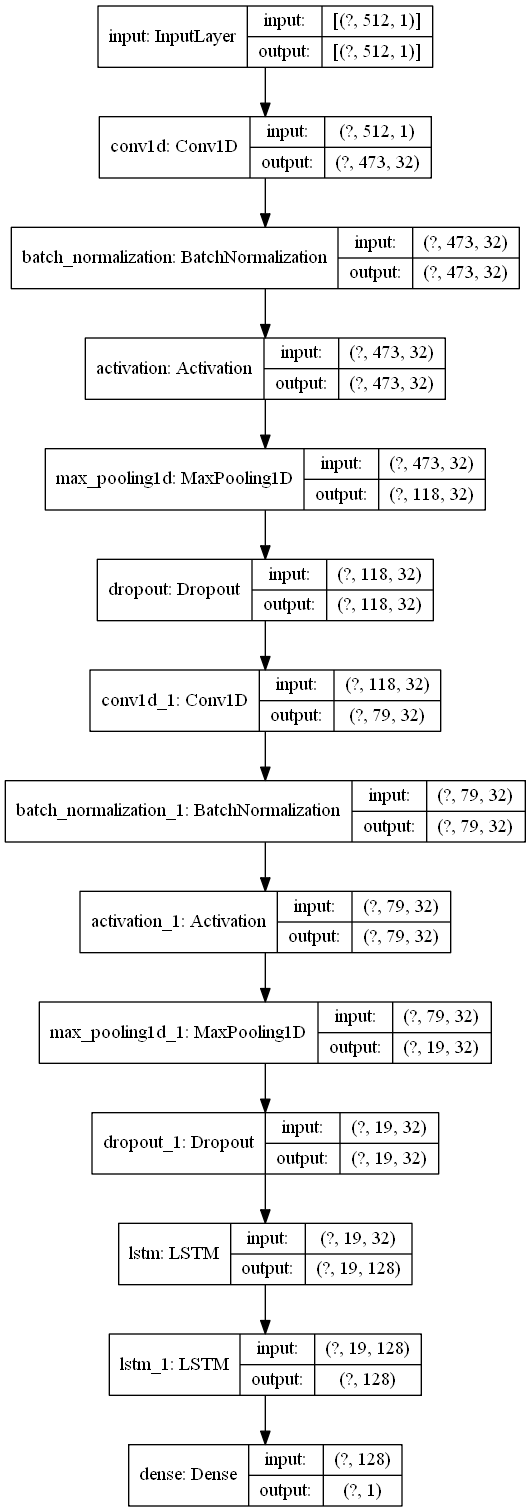

In [4]:
corenet=Core_net()
corenet.summary()
plot_model(corenet,show_shapes=True)

In [4]:
def get_callbacks(name_weights):
    mcp_save = ModelCheckpoint(name_weights+"_weights.hdf5", save_best_only=True, monitor='val_loss', mode='min')
    csv_log=CSVLogger(name_weights+'.csv',separator=',')
    return [mcp_save, csv_log]

In [5]:
def Get_Data():
    TSize=np.zeros(len(Data_files))
    for d in range(len(Data_files)):
        mat = scipy.io.loadmat(Filt_datafiles[d])
        mattrue=scipy.io.loadmat(Data_files[d])
        PPG_BPM=mattrue['data']['label'][0][0][0]
        PPG_Subject=np.array(mat['PPG_filt'])

        #PPG_Train,PPG_True,Loo_Train,Loo_True=get_Tdata(PPG,PPG_True_1,0)
        #print((np.reshape(PPG_Train,(PPG_Train.shape[0],1000,1))).shape)
        if d==0:
            Train_data, Test_data, Train_label, Test_label = train_test_split(PPG_Subject,PPG_BPM,test_size=0.10,shuffle=True)
            
            TrainPPG_Data=np.reshape(Train_data,(Train_data.shape[0],INPUT_SIZE,1))
            TestPPG_Data=np.reshape(Test_data,(Test_data.shape[0],INPUT_SIZE,1))
            TrainPPG_BPM=Train_label
            TestPPG_BPM=Test_label
            TSize[d]=Test_label.shape[0]
           
            #Loo_Train_data= np.reshape(Loo_Train,(1,INPUT_SIZE,1))
            #Loo_True_val=Loo_True
        else:
            Train_data, Test_data, Train_label, Test_label = train_test_split(PPG_Subject,PPG_BPM,test_size=0.10,shuffle=True)
            #TSize=np.concatenate(TSize,Test_label.shape[0])
            TSize[d]=Test_label.shape[0]
          
            TrainPPG_Data=np.concatenate((TrainPPG_Data,np.reshape(Train_data,(Train_data.shape[0],INPUT_SIZE,1))))
            TestPPG_Data=np.concatenate((TestPPG_Data,np.reshape(Test_data,(Test_data.shape[0],INPUT_SIZE,1))))
            TrainPPG_BPM=np.concatenate((TrainPPG_BPM,Train_label))
            TestPPG_BPM=np.concatenate((TestPPG_BPM,Test_label))
            #Loo_Train_data= np.concatenate((Loo_Train_data,np.reshape(Loo_Train,(1,1000,1))))
            #Loo_True_val=np.concatenate((Loo_True_val,Loo_True))
    return (TrainPPG_Data, TestPPG_Data, TrainPPG_BPM, TestPPG_BPM,TSize)

In [6]:
Train_data, Test_data, Train_label, Test_label,TSize=Get_Data()
#Train_data, Test_data, Train_label, Test_label = train_test_split(PPG_Data,TrueBPM,test_size=0.10,shuffle=True)

In [ ]:
TSize.shape

In [7]:
gen_corenet=Core_net()
change="complete"
gen_corenet.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mse','mape'])
weight_dir=BASE_DIR+'/GenModelDtrain/'
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
name_weights = weight_dir+"GenModel"+change

In [8]:
callbacks = get_callbacks(name_weights)
history=gen_corenet.fit(Train_data,Train_label, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(Test_data,Test_label),callbacks=callbacks,use_multiprocessing=False)

Epoch 1/100
2329/2329 [==============================] - 13s 6ms/step - loss: 17.8471 - mse: 816.7010 - mape: 18.8498 - val_loss: 7.8365 - val_mse: 222.7193 - val_mape: 7.7955
Epoch 2/100
2329/2329 [==============================] - 13s 5ms/step - loss: 6.8202 - mse: 161.1681 - mape: 7.3145 - val_loss: 5.7563 - val_mse: 119.3256 - val_mape: 6.3969
Epoch 3/100
2329/2329 [==============================] - 13s 5ms/step - loss: 6.1225 - mse: 139.6797 - mape: 6.6547 - val_loss: 5.5262 - val_mse: 108.4101 - val_mape: 6.1021
Epoch 4/100
2329/2329 [==============================] - 13s 5ms/step - loss: 5.7582 - mse: 128.5739 - mape: 6.2836 - val_loss: 5.5117 - val_mse: 122.5539 - val_mape: 5.9949
Epoch 5/100
2329/2329 [==============================] - 13s 5ms/step - loss: 5.5406 - mse: 121.7059 - mape: 6.0693 - val_loss: 4.8777 - val_mse: 98.3503 - val_mape: 5.3566
Epoch 6/100
2329/2329 [==============================] - 13s 5ms/step - loss: 5.3602 - mse: 117.9998 - mape: 5.8561 - val_loss: 5

2329/2329 [==============================] - 13s 5ms/step - loss: 3.0921 - mse: 40.9522 - mape: 3.4914 - val_loss: 3.8791 - val_mse: 68.1222 - val_mape: 4.3420
Epoch 96/100
2329/2329 [==============================] - 13s 5ms/step - loss: 3.0620 - mse: 39.5134 - mape: 3.4681 - val_loss: 4.0448 - val_mse: 76.0443 - val_mape: 4.5646
Epoch 97/100
2329/2329 [==============================] - 13s 5ms/step - loss: 3.1075 - mse: 41.2020 - mape: 3.5238 - val_loss: 3.7908 - val_mse: 65.6285 - val_mape: 4.2309
Epoch 98/100
2329/2329 [==============================] - 13s 5ms/step - loss: 3.0607 - mse: 39.1152 - mape: 3.4631 - val_loss: 3.8164 - val_mse: 66.6143 - val_mape: 4.3281
Epoch 99/100
2329/2329 [==============================] - 13s 5ms/step - loss: 3.0392 - mse: 39.5935 - mape: 3.4431 - val_loss: 3.8701 - val_mse: 69.8198 - val_mape: 4.3757
Epoch 100/100
2329/2329 [==============================] - 13s 5ms/step - loss: 3.0484 - mse: 39.4926 - mape: 3.4531 - val_loss: 3.9709 - val_mse: 7

In [9]:
def plotHistory(histories, name, metric):
    plt.clf() 
    x_axis = list(range(EPOCHS))
    plt.plot(x_axis, histories.history[metric], label=metric+'_'+name)
    plt.scatter(x_axis, histories.history[metric])
    #for hist, name in zip(histories, names):
    #    plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
    #    plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

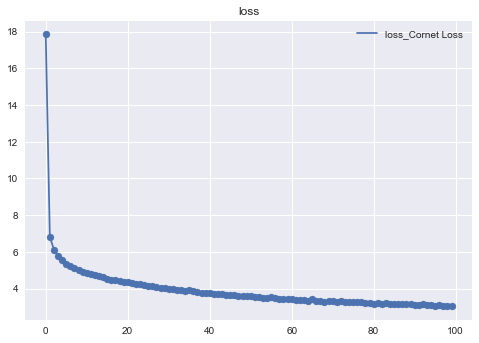

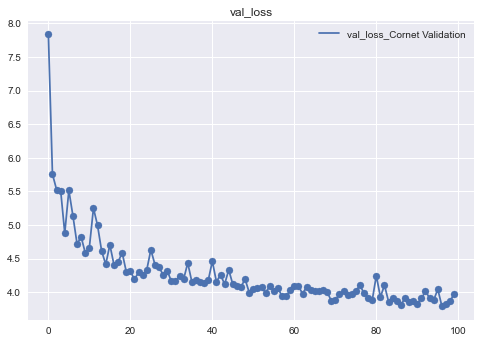

In [10]:
plotHistory(history,'Cornet Loss','loss')
plotHistory(history,'Cornet Validation','val_loss')

In [ ]:
StatList=[]
BPM_dir=BASE_DIR+'/Estimated_gen/'
if not os.path.exists(BPM_dir):
    os.mkdir(BPM_dir)
for d in range(len(Data_files)):
    mat = scipy.io.loadmat(Filt_datafiles[d])
    mattrue=scipy.io.loadmat(Data_files[d])
    PPG_BPM=mattrue['data']['label'][0][0][0]
    PPG_Subject=np.array(mat['PPG_filt'])
    preds=gen_corenet.predict(np.reshape(PPG_Subject,(PPG_Subject.shape[0],INPUT_SIZE,1)))
    filename = BPM_dir+'/Est_'+change+'S'+str(d)+'.mat'
    scipy.io.savemat(filename,{"Estimate":preds,"TrueBPM":PPG_BPM})
    StatList.append(['Subject '+str(d),np.mean(np.absolute(PPG_BPM-preds.T)),np.std(np.absolute(PPG_BPM.T-preds.T))])

In [7]:
corenet.load_weights(BASE_DIR+'/GenModelDtrain/GenModelcomplete_weights.hdf5')

In [28]:
StatList=[]
BPM_dir=BASE_DIR+'/Estimated_DTrain/'
if not os.path.exists(BPM_dir):
    os.mkdir(BPM_dir)
time_start = time.time()
preds=gen_corenet.predict(np.reshape(Test_data[1],(1,INPUT_SIZE,1)))
print((time.time() - time_start))
print(np.mean(np.absolute(Test_label-preds.T)))
print(preds.shape)
print(Test_label.shape)
Test_labelreshape=np.reshape(Test_label,(Test_label.shape[0],1))
for d in range(len(Data_files)):
    if d==0:
        start=int(d)
        end=int(TSize[d]+start)
        StatList.append(['Subject '+str(d),np.mean(np.absolute(Test_labelreshape[start:end]-preds[start:end])),np.std(np.absolute(Test_labelreshape[start:end]-preds[start:end]))])
    else:
        start=int(end)
        end=int(TSize[d]+start)
        StatList.append(['Subject '+str(d),np.mean(np.absolute(Test_labelreshape[start:end]-preds[start:end])),np.std(np.absolute(Test_labelreshape[start:end]-preds[start:end]))])
    
    #print(np.mean(np.absolute(Test_label-preds.T))
#print(np.mean(np.absolute(Test_label-preds.T)))
#
    

3.970872372947728
(6477, 1)
(6477,)


In [28]:
time_start = time.time()
preds=corenet.predict(np.reshape(Test_data[1],(1,INPUT_SIZE,1)))
print((time.time() - time_start))

0.031235456466674805


In [29]:
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
df.to_csv(BPM_dir+'/Resutl_'+change+'.csv')
print (df)

       Subject      Mean      StDev
0    Subject 0  3.849547   6.248822
1    Subject 1  3.550149   5.772437
2    Subject 2  3.128891   5.241371
3    Subject 3  5.416853   7.526926
4    Subject 4  3.650743  10.574799
5    Subject 5  3.290441   8.158337
6    Subject 6  2.274342   2.790699
7    Subject 7  6.444862  10.102809
8    Subject 8  8.090225  11.054798
9    Subject 9  3.218279   6.770754
10  Subject 10  3.779466   6.655424
11  Subject 11  4.974195  10.628025
12  Subject 12  2.380690   4.660713
13  Subject 13  2.823517   4.600851
14  Subject 14  3.020960   5.618212
